## Teleportation

To see the algebra in detail click [here](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action).

This code contains only the Qiskit implementation.

Quantum teleportation, or just teleportation for short, is a protocol where a sender (Alice) transmits a qubit to a receiver (Bob) by making use of a shared entangled quantum state (one e-bit, to be specific) along with two bits of classical communication.

We assume that Alice and Bob share an e-bit: Alice holds a qubit A, Bob holds a qubit B and together they form a pair in a Bell state, let's say $\ket{\phi^+}$. Then, Alice comes into possetion of a qubit Q that she wishes to transmit to Bob. The state of Q is unknown.

At this point, one might ask whether it is possible for Alice and Bob to accomplish their task without even needing to make use of a shared e-bit. In other words, is there any way to transmit a qubit using classical communication alone? The answer is no, it is not possible to transmit quantum information using classical communication alone.

The protocol works as follow:

1. Alice perform CNOT with Q as the control qubit and A being the target qubit. Then apply H to Q
2. Alice then measures A and Q, obtaining a and b; and transmits classical information to Bob
3. With the information Bob has received, he can perform certain operations depending on the value of a and b

Let's start saying, for example, the pair $(A, B)$ forms the Bell state $\ket{\phi^+}=\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})$, but we can start with wither Bell state we desire. Now Alice make her operations, taking Q as $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$ and keeping the convention $\ket{Q}\ket{A}\ket{B}=\ket{QAB}$

1. $ \ket{\psi}\ket{\phi^+}=\frac{1}{\sqrt{2}}[ \alpha\ket{0}(\ket{00}+\ket{11}) + \beta\ket{1}(\ket{00}+\ket{11}) ] $
2. $ CNOT\ket{\psi}\ket{\phi^+} = \frac{1}{\sqrt{2}}[ \alpha\ket{0}(\ket{00}+\ket{11}) + \beta\ket{1}(\ket{10}+\ket{01}) ] $
3. $ H (CNOT\ket{\psi}\ket{\phi^+}) = \frac{1}{2}[ \ket{00}(\alpha\ket{0}+\beta\ket{1}) + \ket{01}(\alpha\ket{1}+\beta\ket{0}) + \ket{10}(\alpha\ket{0}-\beta\ket{1}) + \ket{11}(\alpha\ket{1}-\beta\ket{0}) ] $

At this point, Bob can measure A and Q and he knows what operation need to be applied to retrieve $\ket{\psi}$.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

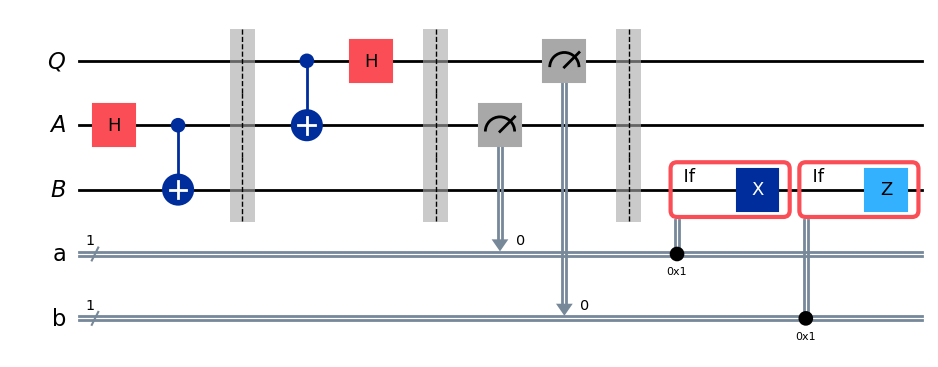

In [2]:
# define the circuit
qubit = QuantumRegister(1, 'Q') # like ancilla qubit
ebit0 = QuantumRegister(1, 'A')
ebit1 = QuantumRegister(1, 'B')
a     = ClassicalRegister(1, 'a')
b     = ClassicalRegister(1, 'b')

qc = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# prepare e-bit used for teleportation (form a Bell state)
qc.h(ebit0)
qc.cx(control_qubit=ebit0, target_qubit=ebit1)
qc.barrier()

# Alice's oeprations
qc.cx(control_qubit=qubit, target_qubit=ebit0)
qc.h(qubit)
qc.barrier()

# Alice measure and sends classical information
qc.measure(ebit0, a)
qc.measure(qubit, b)
qc.barrier()

# Bob uses the classical information to apply certain gates
with qc.if_test((a, 1)):
    qc.x(ebit1)
with qc.if_test((b, 1)):
    qc.z(ebit1)

# draw
qc.draw(output='mpl')

To see that the protocol works correctly, we apply a unitary gate to Q to obtain a rtandom state, and then we apply it to B.

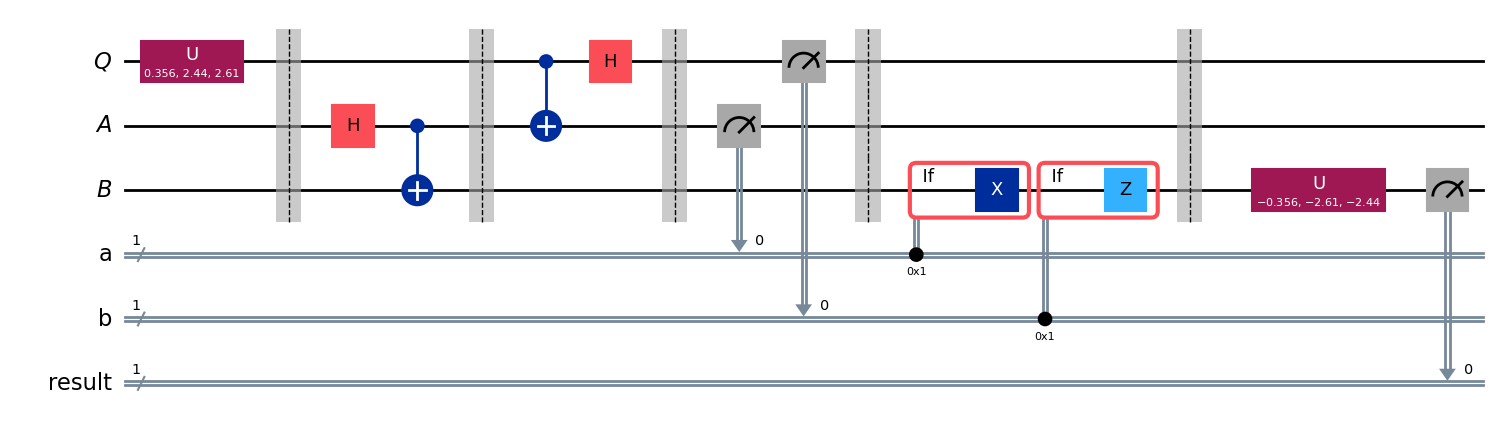

In [3]:
# define random gate
random_gate = UGate(theta=random.random()*2*pi,
                    phi=random.random()*2*pi,
                    lam=random.random()*2*pi)

# create a new circuit with the same qubits but with the additional operations
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# apply random gate to Q
test.append(random_gate, qubit)
test.barrier()

# combine the circuits
test = test.compose(qc)
test.barrier()

# apply the inverse random gate to B
test.append(random_gate.inverse(), ebit1)

# measure
result = ClassicalRegister(1, 'result')
test.add_register(result)
test.measure(ebit1, result)

# draw
test.draw(output='mpl')

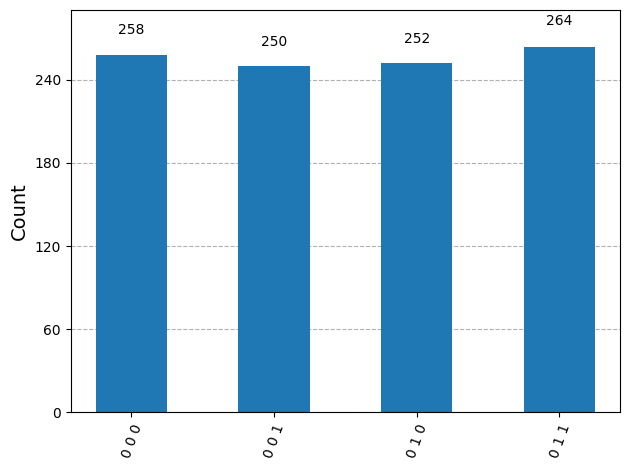

In [4]:
# simulate the circuit
result = AerSimulator().run(test).result()

# plot
stats = result.get_counts()
plot_histogram(stats)

We can filter the results to focus only in the qubit we want. In this case B

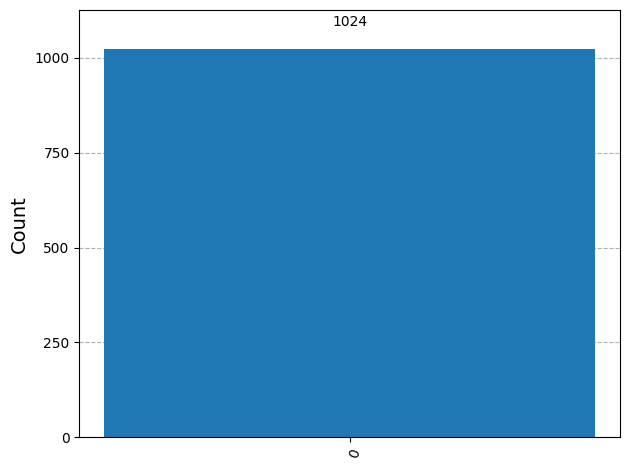

In [5]:
filtered_stats = marginal_distribution(stats, [2])
plot_histogram(filtered_stats)

## Superdense coding

Superdense coding is a protocol that, in some sense, achieves a complementary aim to teleportation. Rather than allowing for the transmission of one qubit using two classical bits of communication (at the cost of one e-bit of entanglement), it allows for the transmission of two classical bits using one qubit of quantum communication (again, at the cost of one e-bit of entanglement).

In greater detail, we have a sender (Alice) and a receiver (Bob) that share one e-bit of entanglement. This means Alice holds A, Bob holds B and together form $\ket{\phi^+}$. Alice wishes to transmit two classical bits to Bob, which we'll denoted by c and d, and she will accomplish this by sending him one qubit.

Fitting the theme of the lesson, one reason why superdense coding is interesting is that it demonstrates a concrete and (in the context of information theory) rather striking use of entanglement. A famous theorem in quantum information theory, known as Holevo's theorem, implies that without the use of a shared entangled state, it is impossible to communicate more than one bit of classical information by sending a single qubit. (Holevo's theorem is more general than this. Its precise statement is technical and requires explanation, but this is one consequence of it.) So, through superdense coding, shared entanglement effectively allows for the doubling of the classical information-carrying capacity of sending qubits.

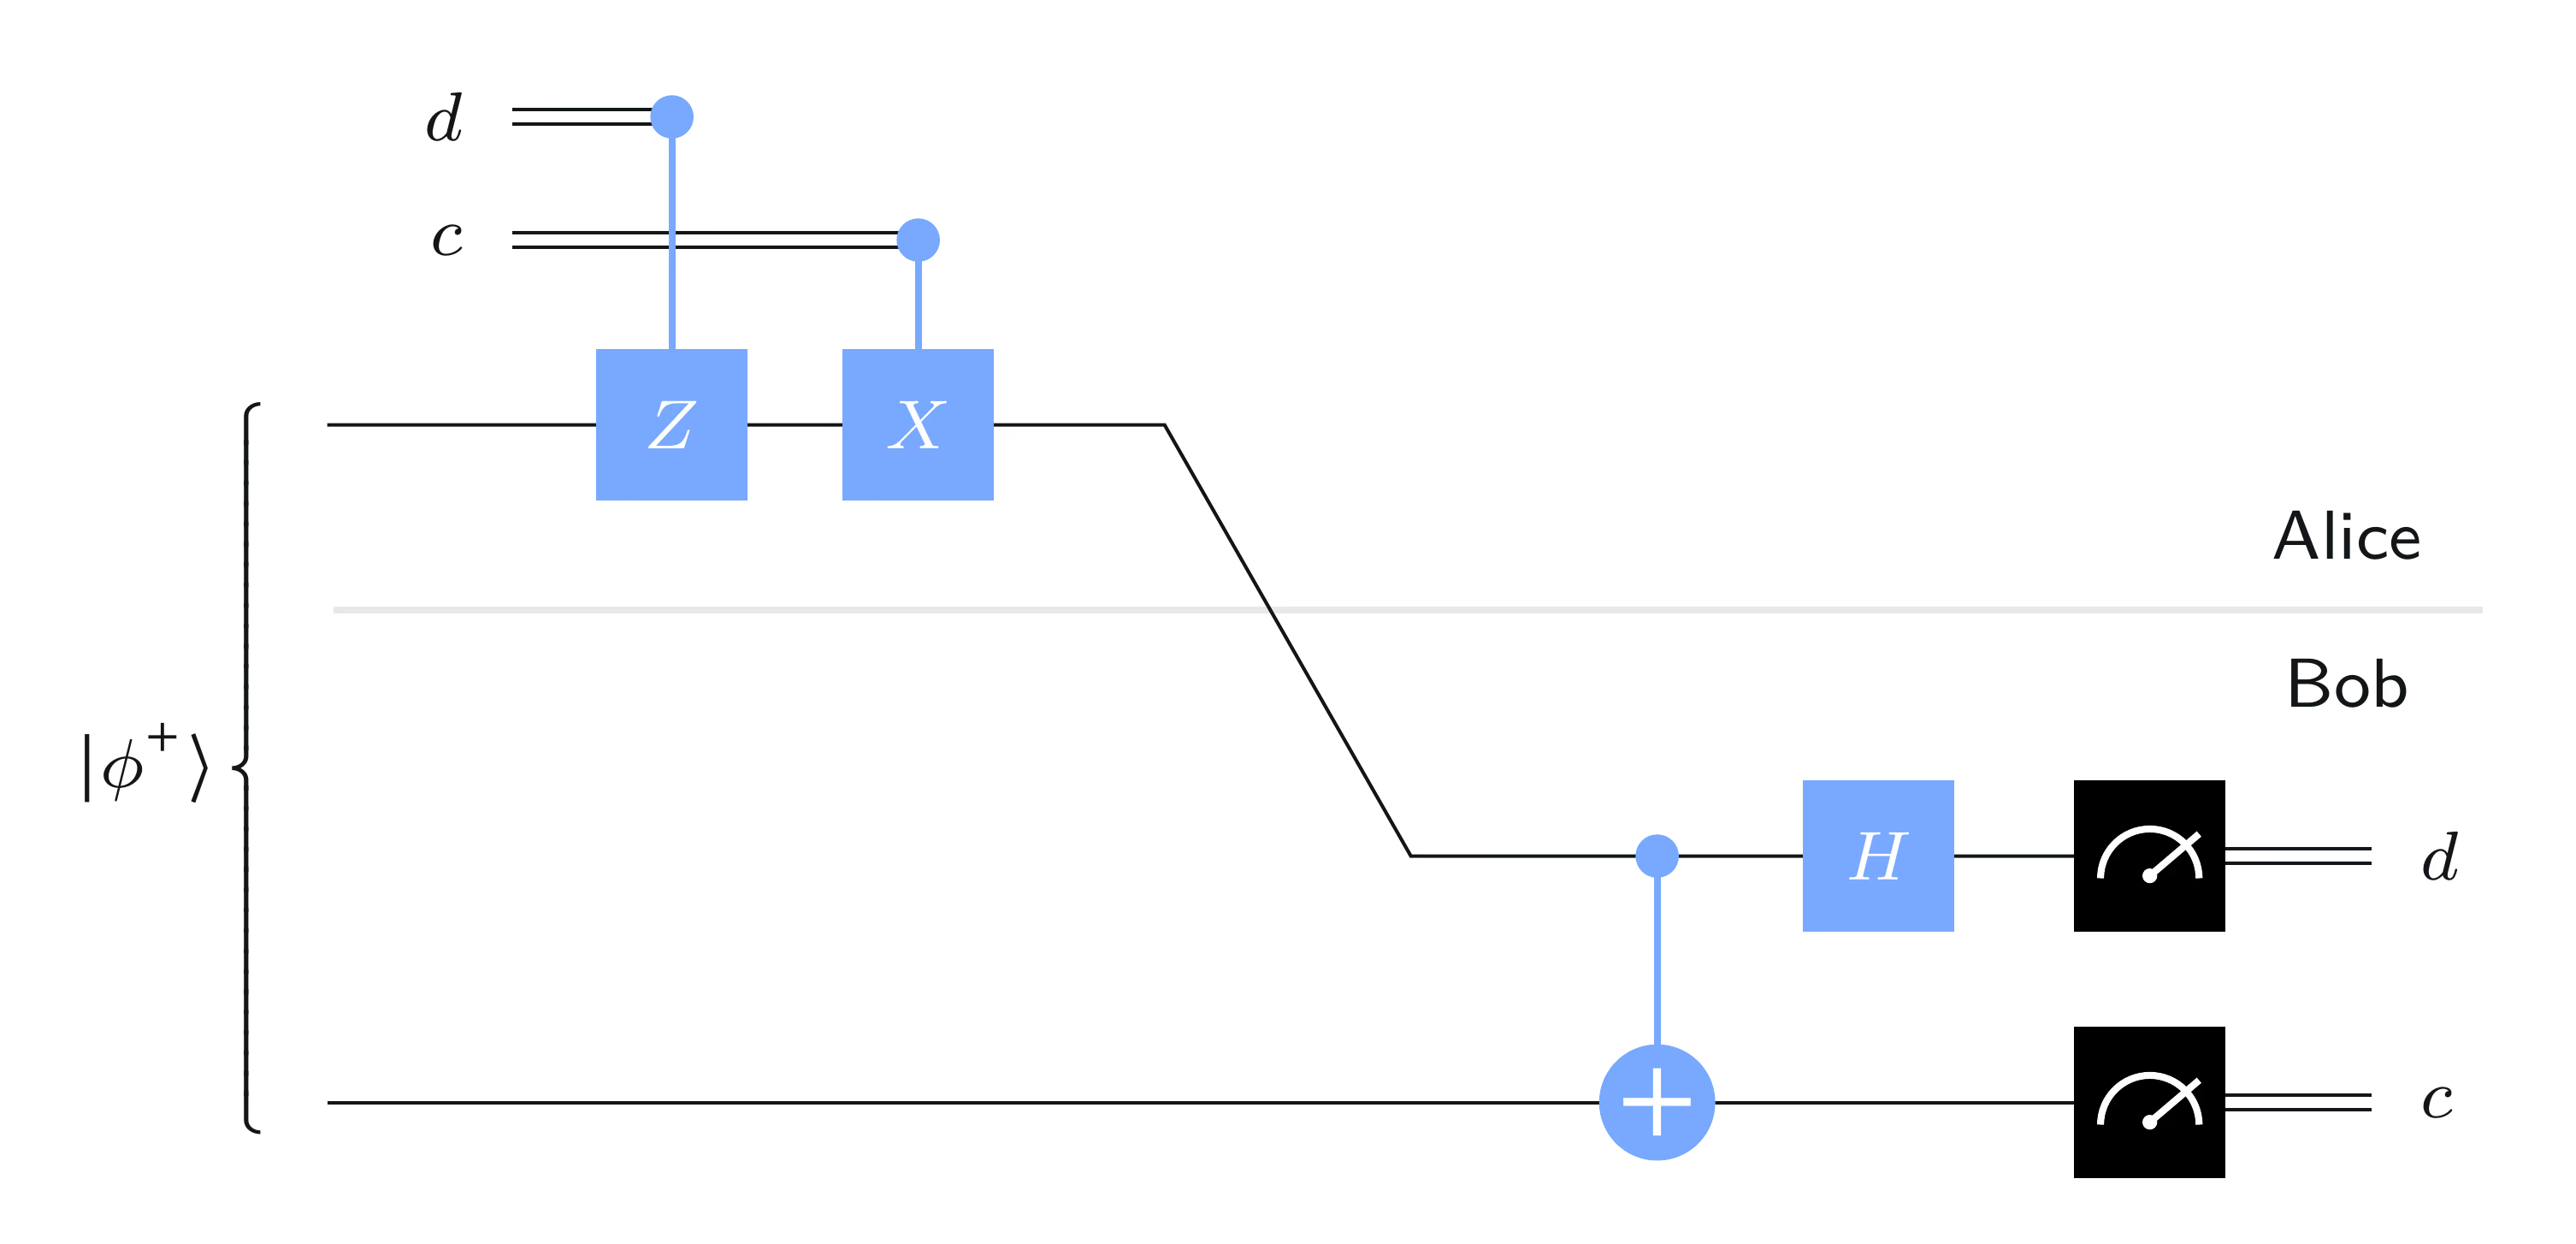

We have the code defined above. So, depending on the valies of *c* and *d*, the state will change.

- Alice's operations on her qubit: $d=1\rightarrow Z$, $d=0\rightarrow I$, $c=1\rightarrow X$, $c=0\rightarrow I$

The Alice's actions modify the Bell state as
$$ I\ket{\phi^+}=\ket{\phi^+}, \quad Z\ket{\phi^+}=\ket{\phi^-}, \quad X\ket{\phi^+}=\ket{\psi^+}, \quad XZ\ket{\phi^+}=\ket{\psi^-}. $$

And the Bob's operations
$$ \ket{\phi^+}\rightarrow\ket{00}, \quad \ket{\phi^-}\rightarrow\ket{01}, \quad \ket{\psi^+}\rightarrow\ket{10}, \quad \ket{\psi^-}\rightarrow-\ket{11}. $$

Hence, the value of $(c, d)$ is know to Bob, depending on the state he gets.

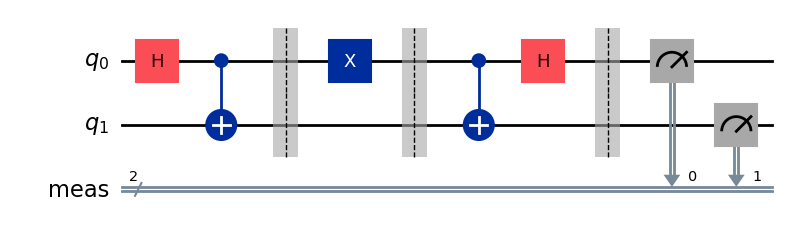

In [6]:
# state the measurements
c = '1'
d = '0'

# create the circuit with no specific names
qc = QuantumCircuit(2)

# prepare ebit for superdense coding
qc.h(0)
qc.cx(control_qubit=0, target_qubit=1)
qc.barrier()

# Alice's operations
if d=='1':
    qc.z(0)
if c=='1':
    qc.x(0)
qc.barrier()

# Bob's operations
qc.cx(control_qubit=0, target_qubit=1)
qc.h(0)
qc.measure_all()

# draw
qc.draw(output='mpl')

Measured 10 with frequency 1024


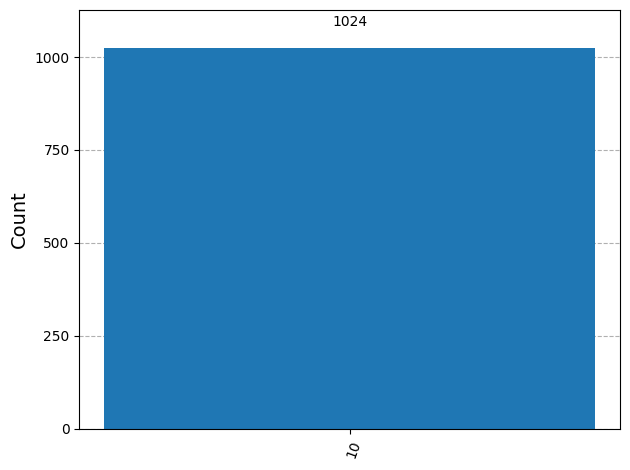

In [7]:
# run the simulation
result = AerSimulator().run(qc).result()
stats = result.get_counts()

for outcome, frequency in stats.items():
    print(f'Measured {outcome} with frequency {frequency}')

plot_histogram(stats)

Now let's use a random qubit as a random bit generator

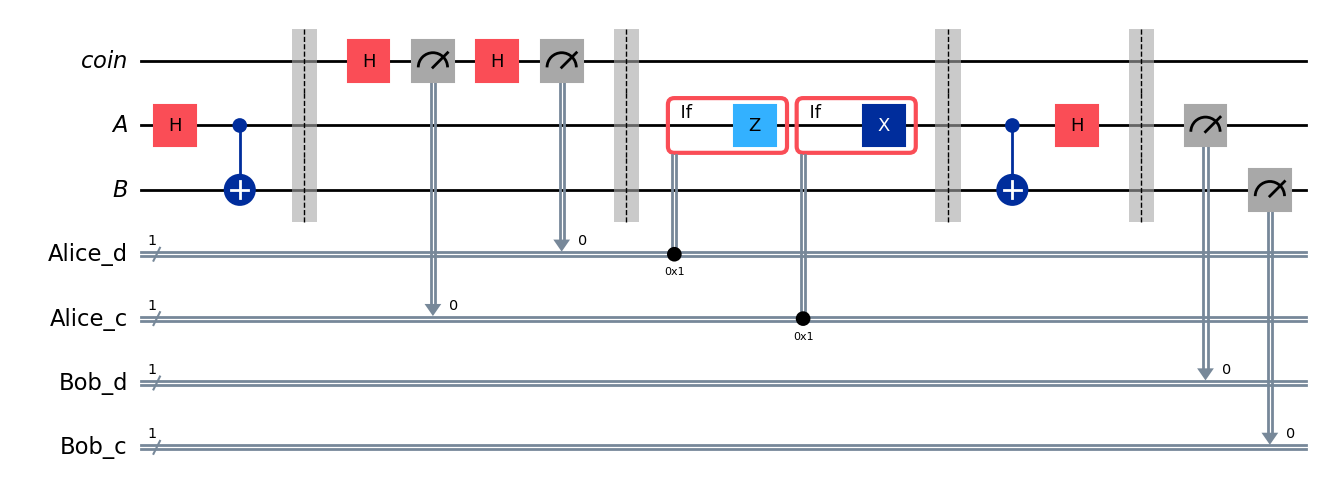

In [8]:
# registers
rgb   = QuantumRegister(1, 'coin')
ebit0 = QuantumRegister(1, 'A')
ebit1 = QuantumRegister(1,'B')

alice_c = ClassicalRegister(1, 'Alice_c')
alice_d = ClassicalRegister(1, 'Alice_d')

# create the circuit
test = QuantumCircuit(rgb, ebit0, ebit1, alice_d, alice_c)

# initialize ebit in Bell state
test.h(ebit0)
test.cx(control_qubit=ebit0, target_qubit=ebit1)
test.barrier()

# use the 'coin' qubit
test.h(rgb)
test.measure(rgb, alice_c)
test.h(rgb)
test.measure(rgb, alice_d)
test.barrier()

# superdense coding protocol
with test.if_test((alice_d, 1), label='Z'):
    test.z(ebit0)
with test.if_test((alice_c, 1), label='X'):
    test.x(ebit0)
test.barrier()

# Bob's operations
test.cx(control_qubit=ebit0, target_qubit=ebit1)
test.h(ebit0)
test.barrier()

bob_c = ClassicalRegister(1, 'Bob_c')
bob_d = ClassicalRegister(1, 'Bob_d')
test.add_register(bob_d)
test.add_register(bob_c)

test.measure(ebit0, bob_d)
test.measure(ebit1, bob_c)

# draw
test.draw(output='mpl')

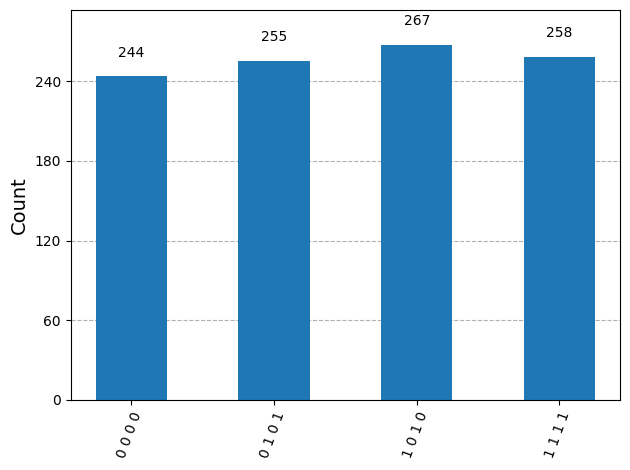

In [9]:
# running the simulation
result = AerSimulator().run(test).result()
stats = result.get_counts()
plot_histogram(stats)

## CHSH game

The CHSH game falls within a class of games known as nonlocal games. Nonlocal games are incredibly interesting and have deep connections to physics, computer science, and mathematics — holding mysteries that still remain unsolved. We'll begin the section by explaining what nonlocal games are, and then we'll focus in on the CHSH game and what makes it interesting.

A nonlocal game is a cooperative game where two players, Alice and Bob, work together to achieve a particular outcome. The game is run by a referee, who behaves according to strict guidelines that are known to Alice and Bob. Alice and Bob can prepare for the game however they choose, but once the game starts they are forbidden from communicating.

The way a nonlocal game works is that the referee first asks each of Alice and Bob a question. We'll use *x* for Alice's question and *y* for Bob's question. The *x, y* are classical.

The referee uses randomness to select the questions. That is $p(x,y)$, and this is known by all participants.

After Alice and Bob receive their questions, they must then provide answers: Alice's answer is *a* and Bob's answer is *b*. At this point the referee makes a decision: Alice and Bob either win or lose depending on whether or not the pair of answers $(a,b)$ is deemed correct for the pair of questions $(x,y)$.

It is the uncertainty about which questions will be asked, and specifically the fact that each player doesn't know the other player's question, that makes nonlocal games challenging for Alice and Bob — just like colluding suspects in different rooms trying to keep their story straight.

- The questions and answers are all bits: $x,y,a,b\in \lbrace 0,1\rbrace$
- The referee chooses the question uniformly, $p(x,y)=1/4$
- The answers win if $a\oplus b = x\wedge y$, and loose otherwise

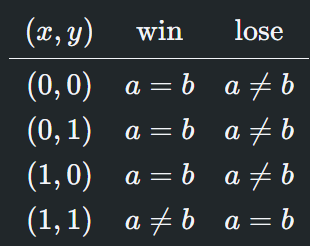

As we just concluded, Alice and Bob cannot do better than winning the CHSH game 75% of the time using a deterministic strategy. Because if $a(0)=a(1)=b(0)=b(1)$, they win in three games, but loose in one. But what about a probabilistic strategy? Could it help Alice and Bob to use randomness — including the possibility of shared randomness, where their random choices are correlated? It turns out that probabilistic strategies don't help at all to increase the probability that Alice and Bob win. This is because every probabilistic strategy can alternatively be viewed as a random selection of a deterministic strategy.

A natural question to ask at this point is whether Alice and Bob can do any better using a quantum strategy. In particular, if they share an entangled quantum state, which they could have prepared prior to playing the game, can they increase their winning probability? The answer is yes, and this is the main point of the example and why it's so interesting.

Define a qubit vector
$$ \ket{\psi_\theta} = \cos\theta\ket{0} + \sin\theta\ket{1}, $$

which satisfies $\braket{\psi_\alpha|\psi_\beta}=\cos(\alpha-\beta)$.

Also we have $\braket{\psi_\alpha\otimes\psi_\beta|\phi^+}=\cos(\alpha-\beta)/\sqrt{2}$.

Define
$$ U_\theta = \ket{0}\bra{\psi_\theta}+\ket{1}\bra{\psi_{\theta+\pi/2}}, \quad U_\theta U_\theta^\dagger=\mathbb{I}. $$

This can be seeing as a matrix $U_\theta=R_y(-2\theta)$.

Now we can describe the quantum strategy.

- **Set-up:** Alice and Bob start the game sharing an e-bit: Alice holds a qubit A and Bob a qubit B, together they form $\ket{\phi^+}$
- **Alice's actions:** If $x=0$ then Alice applies $U_0$, if $x=1$ then applies $U_{\pi/4}$, to A. After that, Alice measures A and sets her answer to *a*
- **Bob's actions:** If $y=0$ applies $U_{\pi/8}$, if $y=1$ applies $U_{-\pi/8}$, to B. After that, Bob measures B and sets his answer to *b*

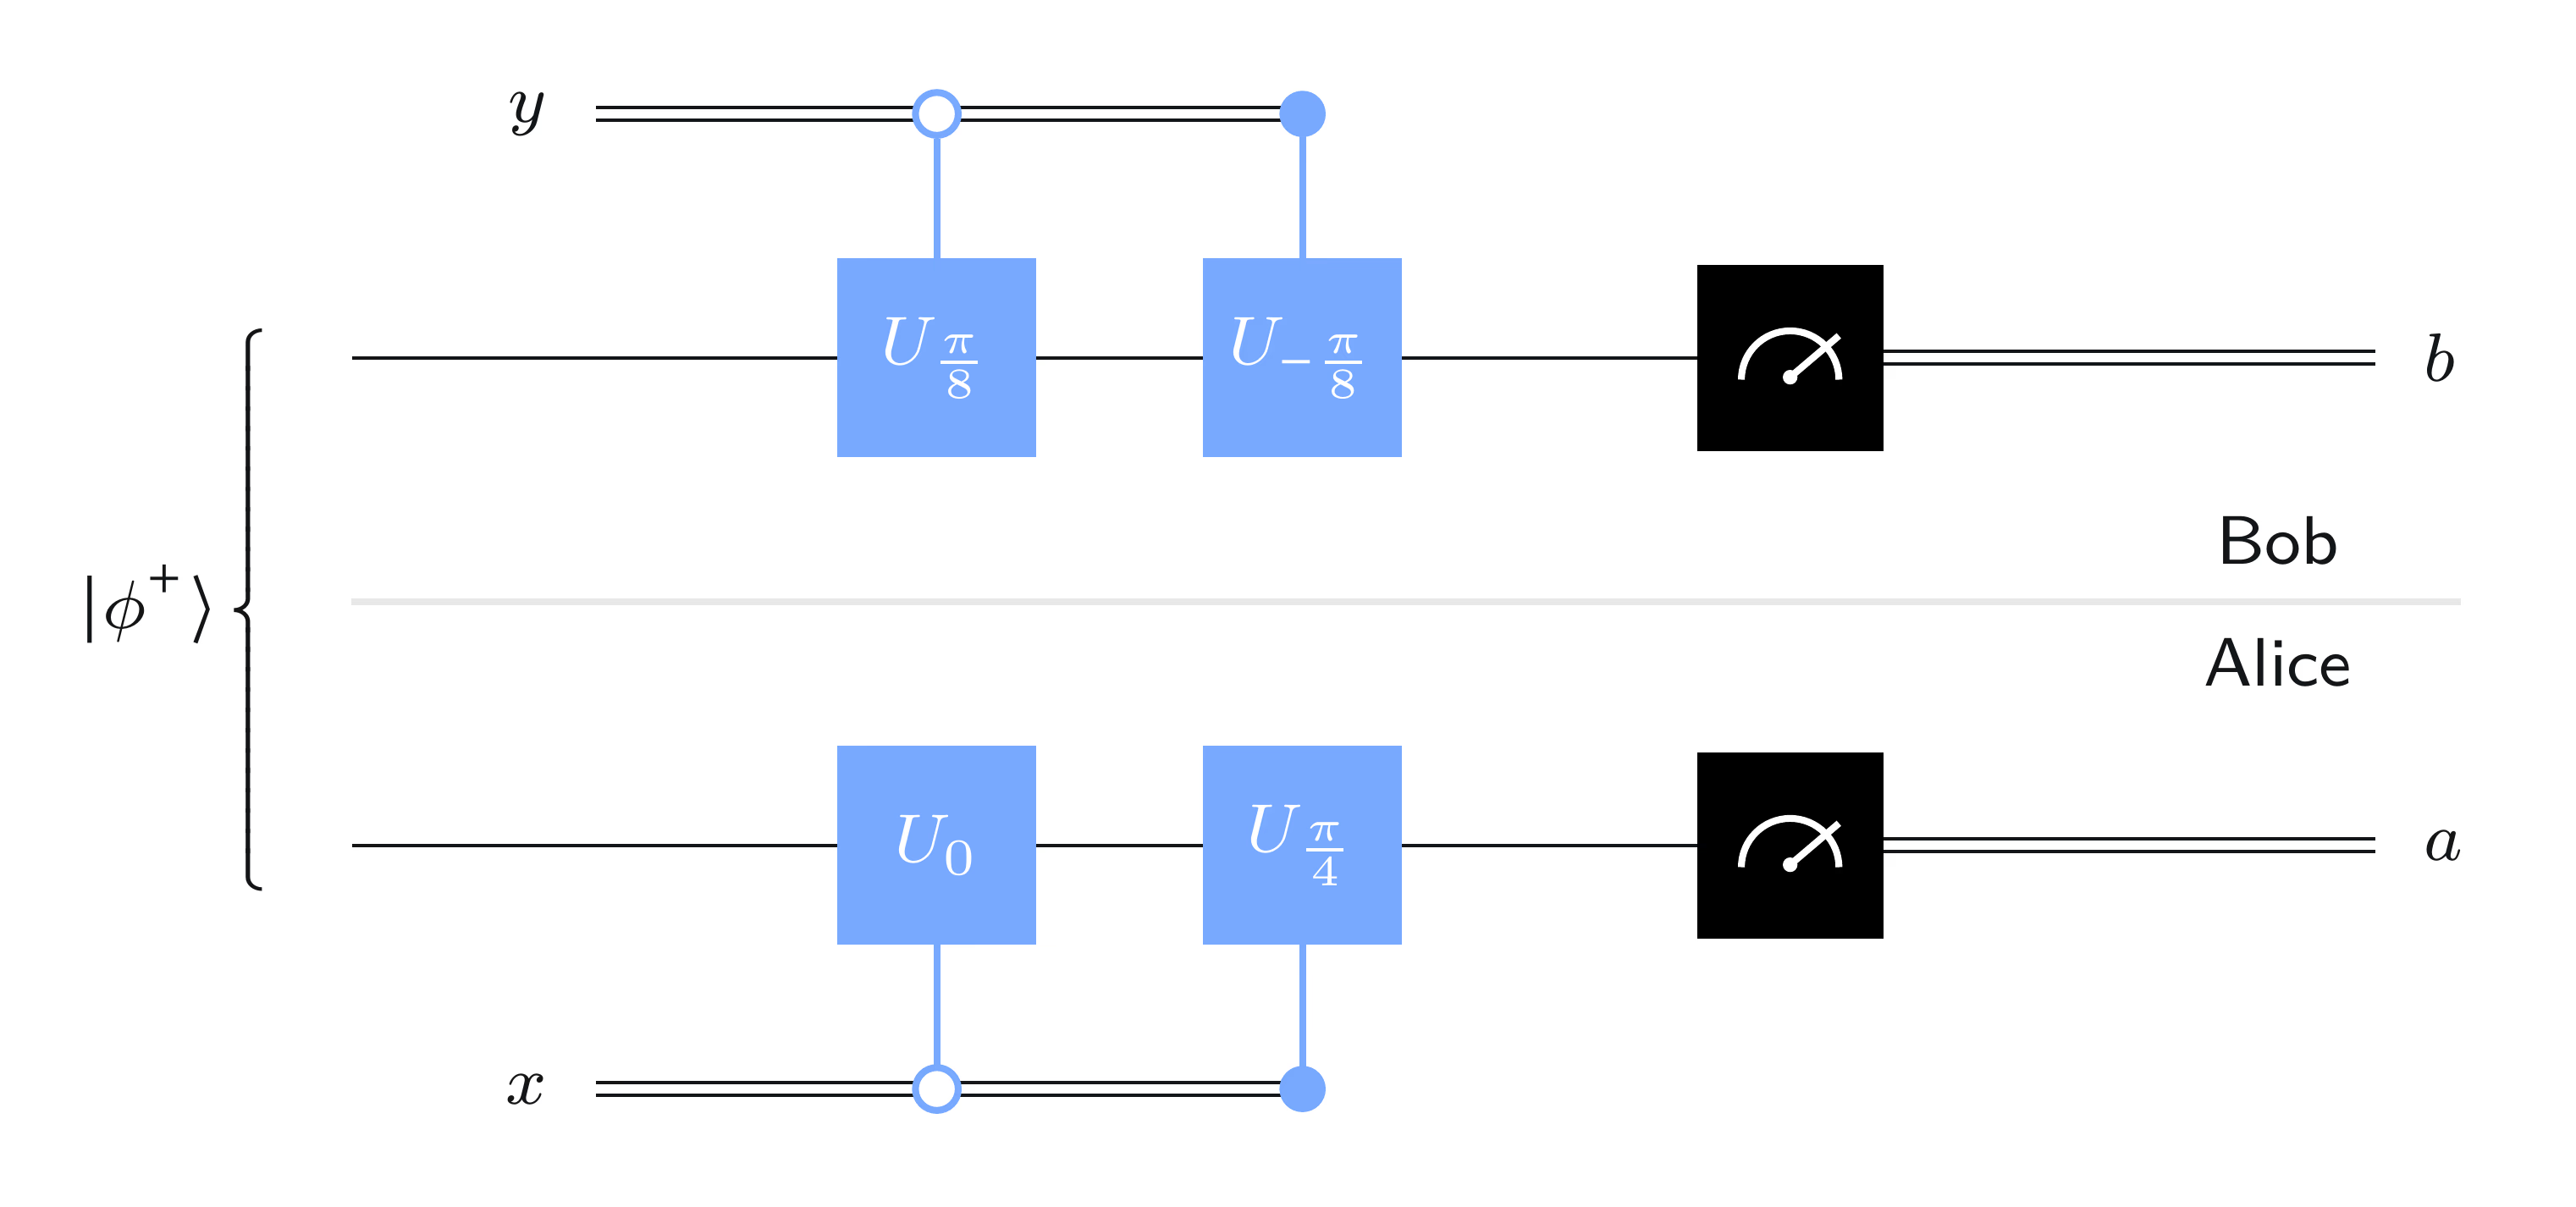

As we see in the code, we start with a Bell state, in this case $\ket{\phi^+}$. And then apply some unitary operations depending on the questions.

Let's the case of $(x,y)=(0,0)$ which have the same results as $(0,1)$ and $(1,0)$. For this we have
$$
\begin{aligned}
U_{0}U_{\pi/8}\ket{\phi^+} &= \ket{00}\braket{\psi_{0}\psi_{\pi/8}|\phi^+} + \ket{01}\braket{\psi_{0}\psi_{5\pi/8}|\phi^+} + \ket{10}\braket{\psi_{\pi/2}\psi_{\pi/8}|\phi^+} + \ket{11}\braket{\psi_{\pi/2}\psi_{5\pi/8}|\phi^+} \\
&= \frac{1}{\sqrt{2}}[ \cos(-\pi/8)\ket{00} + \cos(-5\pi/8)\ket{01} + \cos(3\pi/8)\ket{10} + \cos(-\pi/8)\ket{11} ]
\end{aligned}
$$

This maximizes the probability of winning.
$$ P(a=b)=\frac{2+\sqrt{2}}{4}, \quad P(a\neq b)=\frac{2-\sqrt{2}}{4} $$

In the case of $(x,y)=(1,1)$ is easy to see that occur the contrary
$$ P(a=b)=\frac{2-\sqrt{2}}{4}, \quad P(a\neq b)=\frac{2+\sqrt{2}}{4}, $$
maximizing the winning probability.

In [17]:
# definition of the game
def chsh_game(strategy):
    '''This function runs the CHSH game, using the strategy (a function
    from two bits to two bits), returning 1 for a win and 0 for a loss.'''

    # Choose x and y randomly
    x, y = random.randint(0, 2), random.randint(0, 2)

    # Use the strategy to determine a and b
    a, b = strategy(x, y)

    # Decide if the strategy wins or loses
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

# definition of the quantum circuit
def chsh_circuit(x, y):
    '''This function creates a QuantumCircuit implementing the
    quantum strategy'''

    qc = QuantumCircuit(2, 2)

    # prepare ebit in Bell state
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)
    qc.barrier()

    # Alice's operations
    if x==0:
        qc.ry(theta=0, qubit=0)
    else:
        qc.ry(theta=-pi/2, qubit=0)
    qc.measure(qubit=0, cbit=0)

    # Bob's operations
    if y==0:
        qc.ry(theta=-pi/4, qubit=1)
    else:
        qc.ry(theta=pi/4, qubit=1)
    qc.measure(qubit=1, cbit=1)

    return qc

# definition of the quantum strategy
def quantum_strategy(x, y):
    '''This function runs the correct circuit for each case
    and returns the measurement results'''

    # shots to one to only run it one time
    result     = AerSimulator().run(chsh_circuit(x, y), shots=1).result()
    statistics = result.get_counts()

    # determine the output bits
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]

    return a, b

# definition of the classical strategy
def classical_strategy(x, y):
    # This function implements just one example of an optimal classical
    # strategy for the CHSH game. Other classical strategies can be
    # implemented by changing the bit values assigned to a and b.

    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

(x,y) = (0,0)


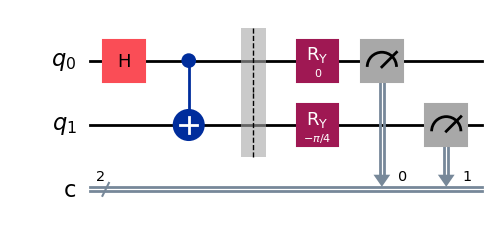

(x,y) = (0,1)


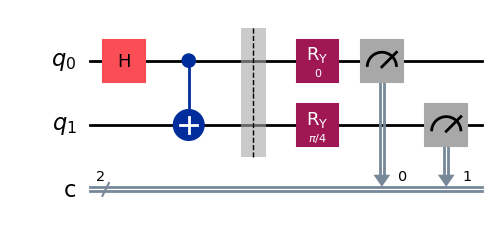

(x,y) = (1,0)


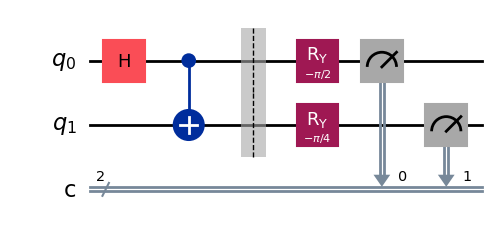

(x,y) = (1,1)


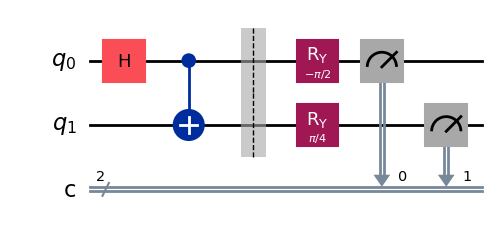

In [15]:
# possible circuits for each case
# Draw the four possible circuits
print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw(output="mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw(output="mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw(output="mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw(output="mpl"))

In [20]:
# play the game
num_games = 100
score = 0

for _ in range(num_games):
    score += chsh_game(quantum_strategy)

print(f'Fraction of the games won: {score/num_games}')

Fraction of the games won: 0.86


In [21]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.724
